For my project I chose a dataset from kaggle titled Car Images Dataset

https://www.kaggle.com/datasets/kshitij192/cars-image-dataset/data

Data summary:

4165 images split into two folders, train and test

The folders both contain images of cars from the brands/models Audi, Hyundai Creta, Mahindra Scorpio, Rolls Royce, Swift, Tata Safari, and Toyota Innova

The goal of my project is to train a model to identify the car brand/model when given an image.

I will start by performing some exploratory analysis and then test and tweak a few different models to see which one gives the best results.

In [61]:
# Load necessary libraries to complete project

import zipfile
import os
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import glob
import tensorflow as tf
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img


# Extract the data from the zip file
zip_file_path = 'CarImages.zip'
extract_path = 'CarImages'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted {zip_file_path} to {extract_path}")

# Paths to the dataset directories
base_path = os.path.join(extract_path, 'Cars Dataset')
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

Extracted CarImages.zip to CarImages


Due to augmented data and incorrect splitting procedures throughout my creation of this project I implemented a section to reset the enviroment so I could easily start over when needed.

In [62]:
# WARNING
# ONLY RUN TO RESET ENVIROMENT AND START OVER

dataset_path = 'CarImages/Cars Dataset'
zip_file_path = 'CarImages.zip'
extract_path = 'CarImages'

# Remove current data and re extract it
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset has been reset by re-extracting {zip_file_path}.")

# WARNING
# ONLY RUN TO RESET ENVIROMENT AND START OVER

Dataset has been reset by re-extracting CarImages.zip.


Now we create a dataframe from the data and use this to split our data into a train, validate, and test set. I also added a little check afterwards by just printing the length of the new split dataframs just to see that the split occured.

In [63]:

# create a dataframe from the data set
def create_dataframe_from_directory(directory_path):
    data = []
    classes = os.listdir(directory_path)  # Subdirectories are class labels
    for label in classes:
        class_path = os.path.join(directory_path, label)
        if os.path.isdir(class_path):  # Check if it's a directory
            for img_file in glob.glob(os.path.join(class_path, '*.jpg')):  # Assuming images are in .jpg format
                data.append({'file_path': img_file, 'label': label})
    return pd.DataFrame(data)

# split into train and test data and then split the test data into validation and test sets
train_df = create_dataframe_from_directory(train_path)
test_df = create_dataframe_from_directory(test_path)


val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'], random_state=42)

# check df size
print(f"Total images in Training DataFrame: {len(train_df)}")
print(f"Total images in Validation DataFrame: {len(val_df)}")
print(f"Total images in Test DataFrame: {len(test_df)}")

Total images in Training DataFrame: 3352
Total images in Validation DataFrame: 406
Total images in Test DataFrame: 407


In the next step we need the split paths to count the number of images in each class correctly, so I saved the split paths to reference.

In [64]:
# Save split paths for future reference
def save_split_to_directory(df, output_folder):
    for _, row in df.iterrows():
        label_folder = os.path.join(output_folder, row['label'])
        os.makedirs(label_folder, exist_ok=True)

        shutil.copy(row['file_path'], label_folder)

split_base = 'split_data'
os.makedirs(split_base, exist_ok=True)

train_output = os.path.join(split_base, 'train')
val_output = os.path.join(split_base, 'val')
test_output = os.path.join(split_base, 'test')

save_split_to_directory(train_df, train_output)
save_split_to_directory(val_df, val_output)
save_split_to_directory(test_df, test_output)

# print to confirm succesful execution
print(f"Train DataFrame: {len(train_df)}")
print(f"Validation DataFrame: {len(val_df)}")
print(f"Test DataFrame: {len(test_df)}")
print("Data successfully saved into split_data/train, split_data/val, and split_data/test!")

Train DataFrame: 3352
Validation DataFrame: 406
Test DataFrame: 407
Data successfully saved into split_data/train, split_data/val, and split_data/test!


Referencing the split paths we now count how many of each class of image is in our folders.

In [65]:
# check total images in each folder as well as under each car brand
train_path = os.path.join(split_base, 'train')
val_path = os.path.join(split_base, 'val')
test_path = os.path.join(split_base, 'test')

def count_images(folder_path):
    category_counts = {}
    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            category_counts[category] = len(os.listdir(category_path))
    return category_counts

train_counts = count_images(train_path)
val_counts = count_images(val_path)
test_counts = count_images(test_path)

# Convert counts
train_counts_df = pd.DataFrame(list(train_counts.items()), columns=['Category', 'Image Count']).sort_values(by='Image Count', ascending=False)
val_counts_df = pd.DataFrame(list(val_counts.items()), columns=['Category', 'Image Count']).sort_values(by='Image Count', ascending=False)
test_counts_df = pd.DataFrame(list(test_counts.items()), columns=['Category', 'Image Count']).sort_values(by='Image Count', ascending=False)

# Print counts
print("Training image counts:")
print(train_counts_df)

print("\nValidation image counts:")
print(val_counts_df)

print("\nTesting image counts:")
print(test_counts_df)

Training image counts:
           Category  Image Count
4              Audi          814
0     Toyota Innova          775
5       Tata Safari          441
2             Swift          424
1  Mahindra Scorpio          316
6       Rolls Royce          311
3     Hyundai Creta          271

Validation image counts:
           Category  Image Count
4              Audi           99
0     Toyota Innova           95
5       Tata Safari           53
2             Swift           51
1  Mahindra Scorpio           37
6       Rolls Royce           37
3     Hyundai Creta           34

Testing image counts:
           Category  Image Count
4              Audi          100
0     Toyota Innova           95
5       Tata Safari           53
2             Swift           51
1  Mahindra Scorpio           38
6       Rolls Royce           37
3     Hyundai Creta           33


With that complete lets have a look at what some of the images actually look like.

Sample images from training category: Toyota Innova


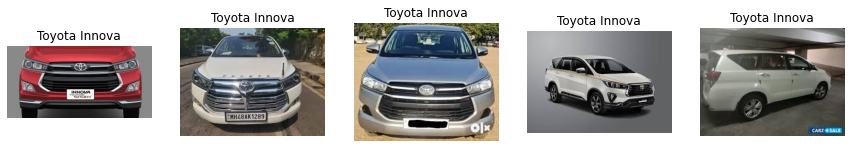

In [66]:
# Visualize some of the data
def show_sample_images(folder_path, category, num_samples=5):
    category_path = os.path.join(folder_path, category)
    sample_images = os.listdir(category_path)[:num_samples]
    plt.figure(figsize=(15, 10))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(category_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.show()

train_categories = os.listdir(train_path)
sample_category = train_categories[0]
print(f"Sample images from training category: {sample_category}")
show_sample_images(train_path, sample_category)

Lets also visualize the number of cars in each class

<Figure size 864x432 with 0 Axes>

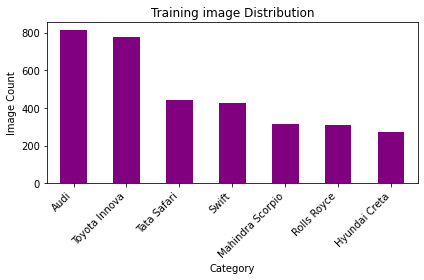

<Figure size 864x432 with 0 Axes>

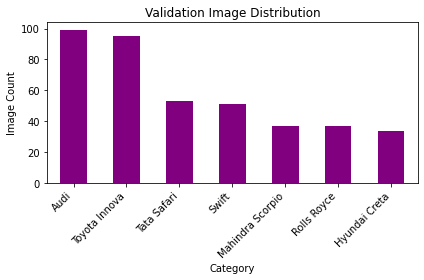

<Figure size 864x432 with 0 Axes>

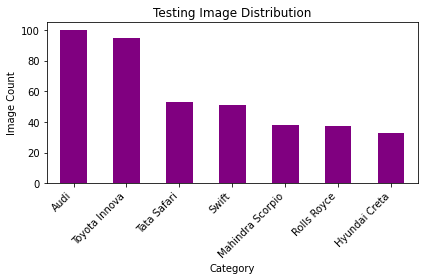

In [93]:
# show the distribution of images across each brand
def plot_image_distribution(counts_df, title):
    plt.figure(figsize=(12, 6))
    counts_df.plot(kind='bar', x='Category', y='Image Count', legend=False, color='purple')
    plt.title(title)
    plt.ylabel('Image Count')
    plt.xlabel('Category')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_image_distribution(train_counts_df.head(10), "Training image Distribution")

plot_image_distribution(val_counts_df.head(10), "Validation Image Distribution")

plot_image_distribution(test_counts_df.head(10), "Testing Image Distribution")

In [68]:
# feature extraction
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features_from_directory(directory_path):
    features = []
    labels = []
    for label in os.listdir(directory_path):
        label_path = os.path.join(directory_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)
                img_array = np.expand_dims(img_array, axis=0)
                
                # Extract features
                feature = model.predict(img_array)
                features.append(feature.flatten())
                labels.append(label)
    return np.array(features), np.array(labels)


train_features, train_labels = extract_features_from_directory(train_path)


With basic analysis and visualization done lets move on to our first model, the TSNE Model. This model is an unsupervised model and will be useful for identifying if there are any patterns or obvious clusters in our data. I also will add the silhouette score below the cluster to see how it does.

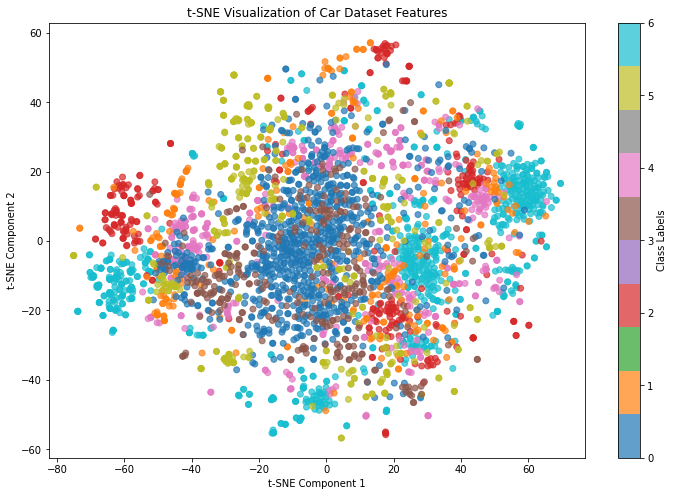

In [69]:
# Create and visualize a TSNE model
encoder = LabelEncoder()
numeric_labels = encoder.fit_transform(train_labels)

tsne = TSNE(n_components=2, perplexity=50, random_state=42)
reduced_features = tsne.fit_transform(train_features)


plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=numeric_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Class Labels')
plt.title('t-SNE Visualization of Car Dataset Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [70]:
# display TSNE results
silhouette = silhouette_score(reduced_features, train_labels)
print(f"Silhouette Score: {silhouette}")

Silhouette Score: -0.09249912202358246


Unfortunately it is quite obvious that the TSNE model did not provide even remotely good clustering. This is clear given the high amount of overlap between points on the plot as well as by the negative silhouette score, which indicates that most points are closer to other unrelated points than they are to points similar to themselves.

I will also try a PCA model which is a linear reduction compared to the TSNE model's non-linear reduction

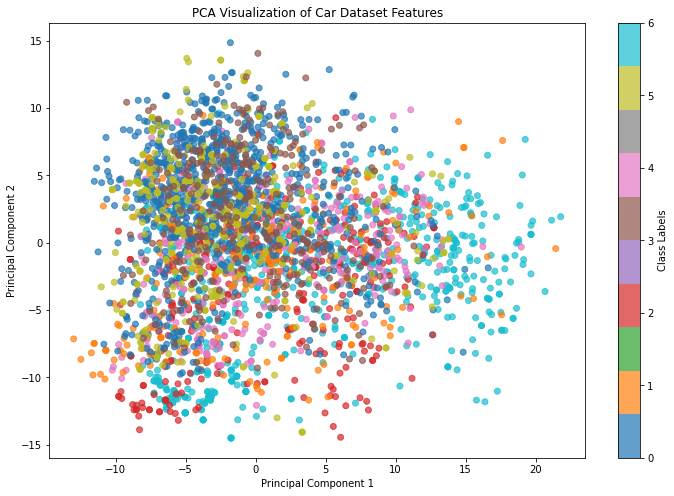

In [71]:
# Create and visualize a PCA Model
pca = PCA(n_components=2)
pca_features = pca.fit_transform(train_features)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=numeric_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Class Labels')
plt.title('PCA Visualization of Car Dataset Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [72]:
silhouette = silhouette_score(pca_features, train_labels)
print(f"Silhouette Score: {silhouette}")

Silhouette Score: -0.08666159212589264


The PCA model did not delivery great results either, so lets move on and try a different type of model like random forest.

Before wasting too much time, lets test for the best parameters and use those on our model.

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Validation Accuracy: 0.79
Classification Report on Validation Data:
                  precision    recall  f1-score   support

            Audi       0.65      0.91      0.76       163
   Hyundai Creta       0.95      0.33      0.49        54
Mahindra Scorpio       0.93      0.86      0.89        63
     Rolls Royce       0.89      0.39      0.54        62
           Swift       0.86      0.71      0.77        85
     Tata Safari       0.96      0.81      0.88        89
   Toyota Innova       0.78      0.97      0.87       155

        accuracy                           0.79       671
       macro avg       0.86      0.71      0.74       671
    weighted avg       0.82      0.79      0.77       671



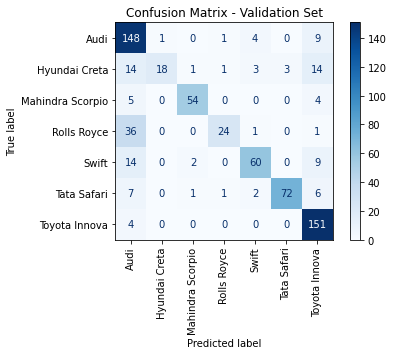

In [73]:
# Encode the labels for the Random Forest
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)

X_train, X_val, y_train, y_val = train_test_split(
    train_features, encoded_train_labels, test_size=0.2, stratify=encoded_train_labels, random_state=42
)

# Initialize and train
rf_model = RandomForestClassifier(random_state=42)

# hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

val_predictions = best_rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

print("Classification Report on Validation Data:")
print(classification_report(y_val, val_predictions, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(y_val, val_predictions)
ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Validation Set")
plt.show()

With the model complete, lets display the results and see how it did.

The results were quite very impressive, regardless I want to try another method and see if it performs better. First off lets create some augmented data to give our model more to work with. I then want to use this new data and try training a neural network

In [75]:
# create image generators for our CNN/normalize and augment data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255) 

In [76]:
# create batches
train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True 
)

val_gen = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

test_gen = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

Found 3352 images belonging to 7 classes.
Found 406 images belonging to 7 classes.
Found 407 images belonging to 7 classes.


In [78]:
# Class labels
class_labels = train_gen.class_indices
print("Class Labels:")
print(class_labels)

# display total
num_classes = len(class_labels)
print(f"Number of classes: {num_classes}")

Class Labels:
{'Audi': 0, 'Hyundai Creta': 1, 'Mahindra Scorpio': 2, 'Rolls Royce': 3, 'Swift': 4, 'Tata Safari': 5, 'Toyota Innova': 6}
Number of classes: 7


In [79]:
# create the model

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Add dropout to reduce overfitting
    layers.Dense(len(class_labels), activation='softmax')
])

Now we have created the layers of our CNN model using relu as our activation method, hopefully allowing it to understand the more complex patterns in the images.

In [80]:

# optimize the learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2000,
    decay_rate=0.9
)

# Compile
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

I also wanted to add control over the learning rate so I used a learning rate schedule to adjust the rate slightly over the course of the model. I also used early stopping so that we dont waste time running the model if it is no longer learning.

In [81]:
# implement early stopping after 3 epochs with no improvement
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)
EPOCHS = 10
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stopping]
)

Epoch 1/10
105/105 [==============================] - 82s 776ms/step - loss: 1.8495 - accuracy: 0.2631 - precision: 0.4000 - recall: 0.0089 - val_loss: 1.7452 - val_accuracy: 0.3448 - val_precision: 0.6667 - val_recall: 0.0148
Epoch 2/10
105/105 [==============================] - 73s 692ms/step - loss: 1.7822 - accuracy: 0.3192 - precision: 0.5398 - recall: 0.0283 - val_loss: 1.7264 - val_accuracy: 0.3744 - val_precision: 0.7143 - val_recall: 0.0123
Epoch 3/10
105/105 [==============================] - 72s 686ms/step - loss: 1.7198 - accuracy: 0.3577 - precision: 0.5256 - recall: 0.0459 - val_loss: 1.6339 - val_accuracy: 0.4138 - val_precision: 0.6226 - val_recall: 0.0813
Epoch 4/10
105/105 [==============================] - 73s 690ms/step - loss: 1.6797 - accuracy: 0.3798 - precision: 0.5923 - recall: 0.0785 - val_loss: 1.7363 - val_accuracy: 0.3399 - val_precision: 0.4918 - val_recall: 0.1478
Epoch 5/10
105/105 [==============================] - 72s 685ms/step - loss: 1.6221 - accura

In [82]:
# display results of the model
results = model.evaluate(test_gen)
test_loss = results[0]
test_accuracy = results[1]
precision = results[2]
recall = results[3]

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")

13/13 [==============================] - 2s 111ms/step - loss: 1.1257 - accuracy: 0.5823 - precision: 0.8069 - recall: 0.4005
Test Loss: 1.1256886720657349
Test Accuracy: 0.5823096036911011
Test Precision: 0.8069307208061218
Test Recall: 0.4004913866519928


The results show improvement over the RF model, but lets visualize it to see if there are any obvious issues we can fix.

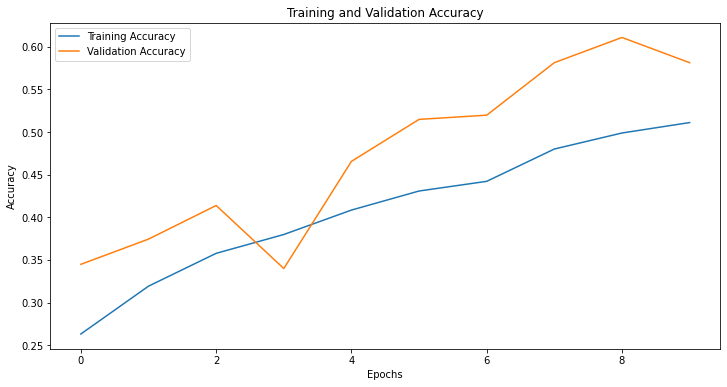

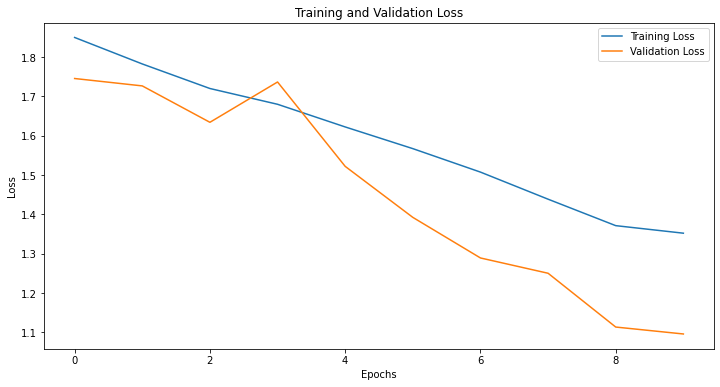

In [83]:
# visualize the results over time

# accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

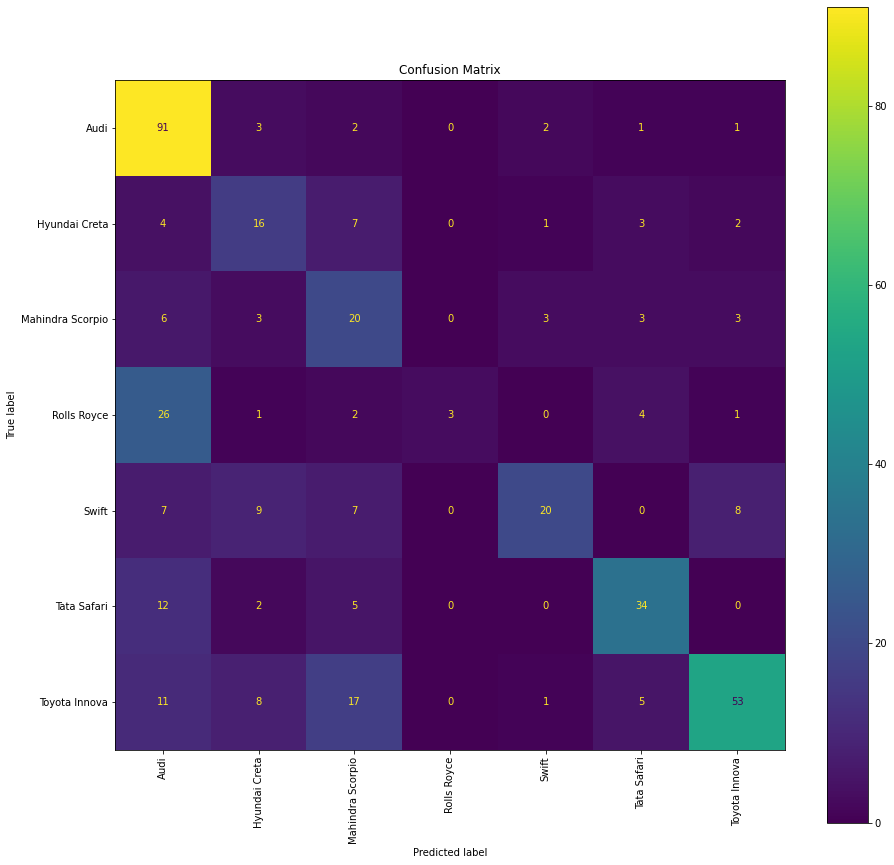

Classification Report:
                  precision    recall  f1-score   support

            Audi       0.58      0.91      0.71       100
   Hyundai Creta       0.38      0.48      0.43        33
Mahindra Scorpio       0.33      0.53      0.41        38
     Rolls Royce       1.00      0.08      0.15        37
           Swift       0.74      0.39      0.51        51
     Tata Safari       0.68      0.64      0.66        53
   Toyota Innova       0.78      0.56      0.65        95

        accuracy                           0.58       407
       macro avg       0.64      0.51      0.50       407
    weighted avg       0.66      0.58      0.56       407



In [84]:
# show how the model predicted compared to what the true classification was using a confusion matrix
true_labels = test_gen.classes
predictions = model.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_gen.class_indices.keys()))
disp.plot(include_values=True, xticks_rotation='vertical', cmap='viridis', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=list(test_gen.class_indices.keys())))

The results are fairly Inconsistent and the rolls royce class seems to be the worst with only one being accurately predicted. To try and fix this I want to add some more augmented data, an optimized learning rate, and some class weights to hopefully improve the score.

In [85]:
# further augment the data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [86]:
# initialize optimizer and set a very low learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

In [87]:
# implement class weights to improve results
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# train model
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=class_weights_dict
)

Class Weights: {0: 0.5882765882765882, 1: 1.7670005271481286, 2: 1.515370705244123, 3: 1.5397335783187873, 4: 1.1293800539083558, 5: 1.0858438613540655, 6: 0.6178801843317973}
Epoch 1/15
105/105 [==============================] - 96s 905ms/step - loss: 1.4343 - accuracy: 0.4973 - precision: 0.7458 - recall: 0.2530 - val_loss: 1.1955 - val_accuracy: 0.5764 - val_precision: 0.7361 - val_recall: 0.3916
Epoch 2/15
105/105 [==============================] - 97s 921ms/step - loss: 1.3559 - accuracy: 0.5173 - precision: 0.7676 - recall: 0.2927 - val_loss: 1.1583 - val_accuracy: 0.5764 - val_precision: 0.7799 - val_recall: 0.4015
Epoch 3/15
105/105 [==============================] - 82s 775ms/step - loss: 1.3397 - accuracy: 0.5140 - precision: 0.7577 - recall: 0.2930 - val_loss: 1.1256 - val_accuracy: 0.6034 - val_precision: 0.8010 - val_recall: 0.3867
Epoch 4/15
105/105 [==============================] - 86s 820ms/step - loss: 1.2376 - accuracy: 0.5621 - precision: 0.7527 - recall: 0.3505 - v

In [88]:
# display results of the model
results = model.evaluate(test_gen)
test_loss = results[0]
test_accuracy = results[1]
precision = results[2]
recall = results[3]

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")

13/13 [==============================] - 2s 161ms/step - loss: 0.7916 - accuracy: 0.7346 - precision: 0.8173 - recall: 0.6486
Test Loss: 0.7915731072425842
Test Accuracy: 0.7346437573432922
Test Precision: 0.8173374533653259
Test Recall: 0.6486486196517944


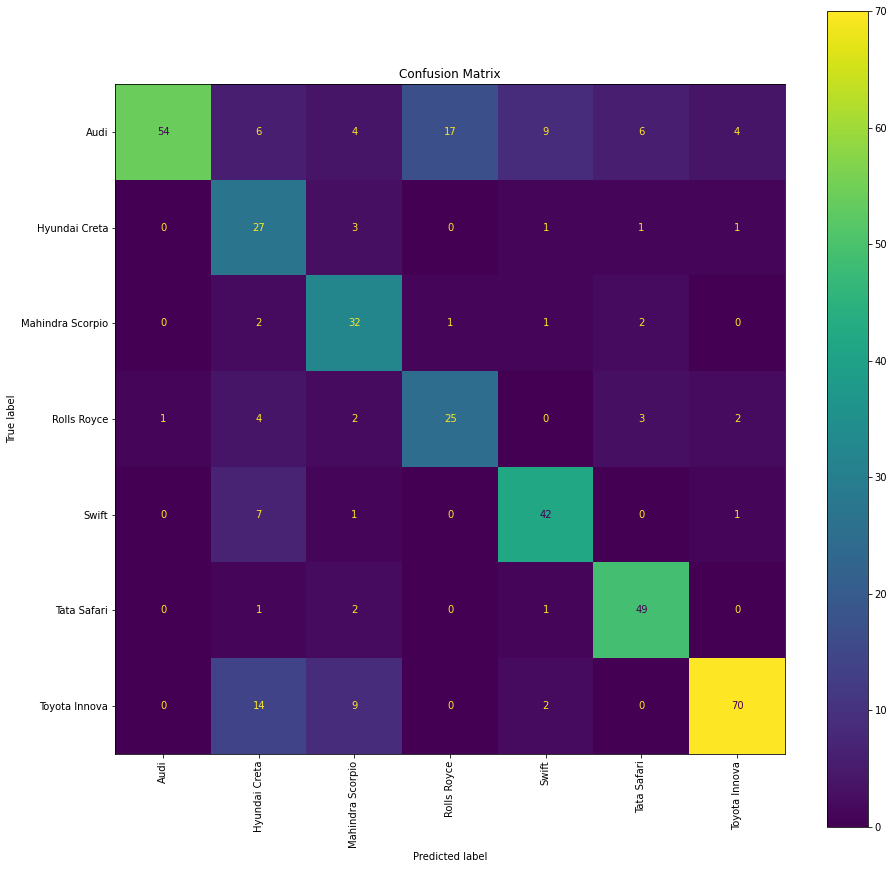

Classification Report:
                  precision    recall  f1-score   support

            Audi       0.98      0.54      0.70       100
   Hyundai Creta       0.44      0.82      0.57        33
Mahindra Scorpio       0.60      0.84      0.70        38
     Rolls Royce       0.58      0.68      0.63        37
           Swift       0.75      0.82      0.79        51
     Tata Safari       0.80      0.92      0.86        53
   Toyota Innova       0.90      0.74      0.81        95

        accuracy                           0.73       407
       macro avg       0.72      0.77      0.72       407
    weighted avg       0.79      0.73      0.74       407



In [89]:
# show how the model predicted compared to what the true classification was using a confusion matrix
true_labels = test_gen.classes
predictions = model.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_gen.class_indices.keys()))
disp.plot(include_values=True, xticks_rotation='vertical', cmap='viridis', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=list(test_gen.class_indices.keys())))

With these changes made we are now achieving much higher scores of 73% accuracy, meaning this model is perfoming well, but still not as good as the random forest model. In conculsion, the Random Forest model proved to be the most effective model. The images were too complex to distinguish features using the TSNE or PCA models, but the complexity was handled well by the Random Forest and CNN models.